In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from src.utils import get_root_dir

### This Notebook will be used to test models for time-series forecasting on crime data

In [2]:
get_root_dir()

'/home/jamie/code/JamieW365/londoncrime'

In [3]:
df_crime = pd.read_csv(os.path.join(get_root_dir(), 'data/processed/final.csv'))
df_crime.head()

,Major,Minor,Borough,Date,Count,Population
0,Arson and Criminal Damage,Arson,Barking and Dagenham,2010-04-01,6.0,182838
1,Arson and Criminal Damage,Arson,Barking and Dagenham,2010-05-01,5.0,182838
2,Arson and Criminal Damage,Arson,Barking and Dagenham,2010-06-01,11.0,182838
3,Arson and Criminal Damage,Arson,Barking and Dagenham,2010-07-01,10.0,182838
4,Arson and Criminal Damage,Arson,Barking and Dagenham,2010-08-01,6.0,182838


In [4]:
df_crime['Count_Per_1000'] = df_crime['Count'] / (df_crime['Population'] / 1000)

In [5]:
total_crime_trend = df_crime.groupby('Date').sum(numeric_only=True)['Count_Per_1000']
total_crime_trend

Date
2010-04-01    268.322545
2010-05-01    274.519513
2010-06-01    277.427047
2010-07-01    281.972314
2010-08-01    261.862011
                 ...    
2023-07-01    273.811522
2023-08-01    262.543980
2023-09-01    263.757539
2023-10-01    280.749514
2023-11-01    271.461315
Name: Count_Per_1000, Length: 164, dtype: float64

<Axes: xlabel='Date'>

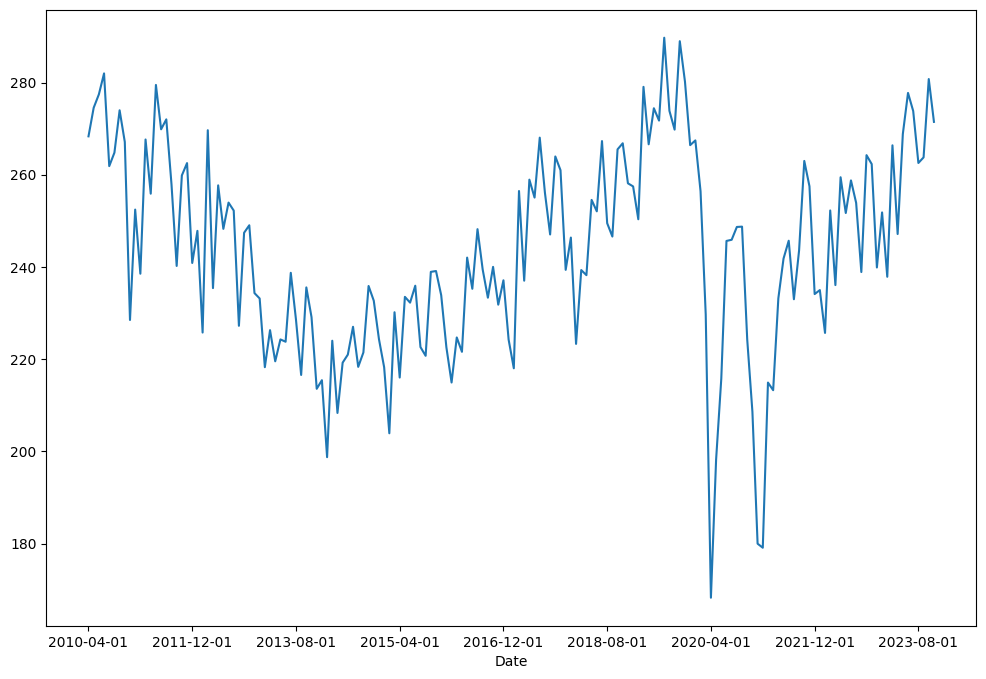

In [6]:
total_crime_trend.plot(figsize=(12,8))

In [7]:
from statsmodels.tsa.seasonal import seasonal_decompose

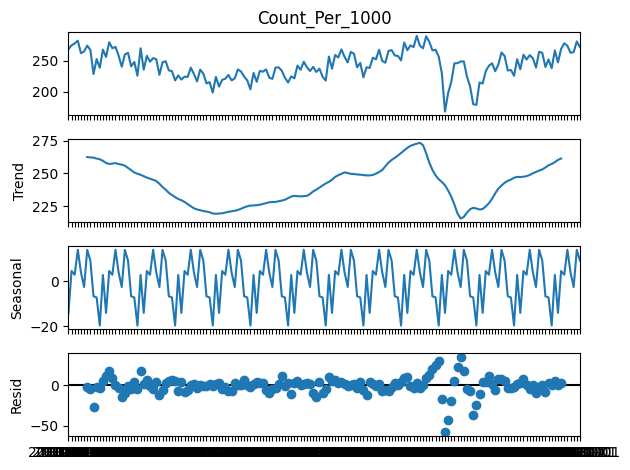

In [8]:
seasonal_decomp = seasonal_decompose(x=total_crime_trend, model="additive", period=12)
seasonal_decomp.plot();

In [26]:
df_train = total_crime_trend.iloc[:-6]
df_test = total_crime_trend.iloc[-6:]

total_crime_trend.shape, df_train.shape, df_test.shape

((164,), (158,), (6,))

<Axes: xlabel='Date'>

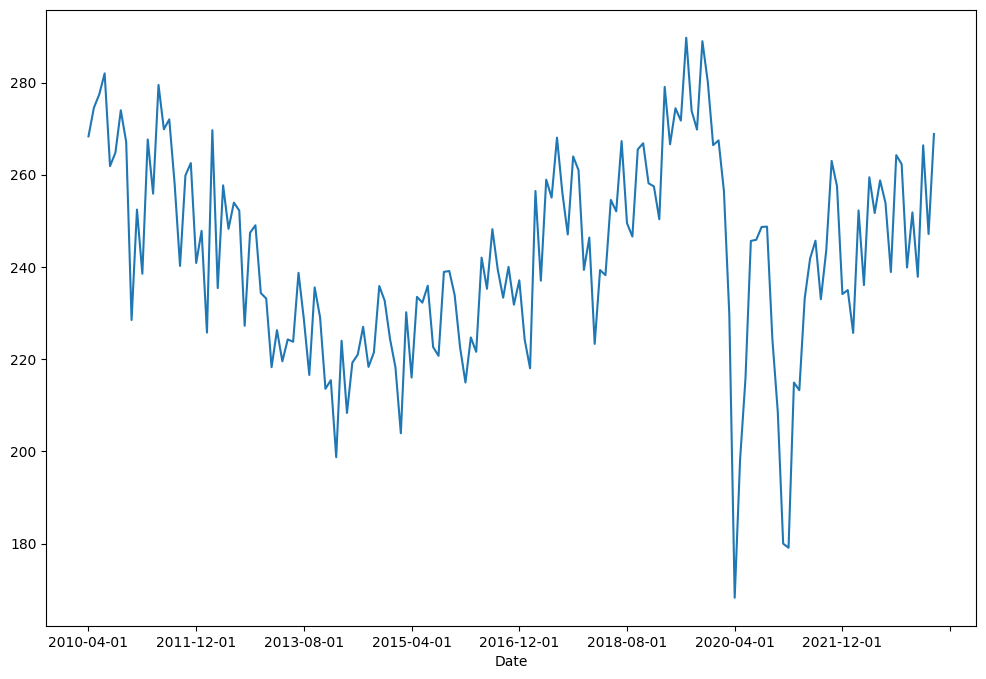

In [27]:
df_train.plot(figsize=(12, 8))

In [33]:
s_dec_additive = seasonal_decompose(x=df_train, model="additive", period=12)
s_dec_multiplicative = seasonal_decompose(x=df_train, model="multiplicative", period=12)


In [45]:
observed = s_dec_additive.observed
trend = s_dec_additive.trend
seasonal = s_dec_additive.seasonal
residual = s_dec_additive.resid

df_additive = pd.DataFrame({"observed":observed, "trend":trend, "seasonal":seasonal,"residual":residual})

In [36]:
observed = s_dec_multiplicative.observed
trend = s_dec_multiplicative.trend
seasonal = s_dec_multiplicative.seasonal
residual = s_dec_multiplicative.resid

df_multiplicative = pd.DataFrame({"observed":observed, "trend":trend, "seasonal":seasonal,"residual":residual})

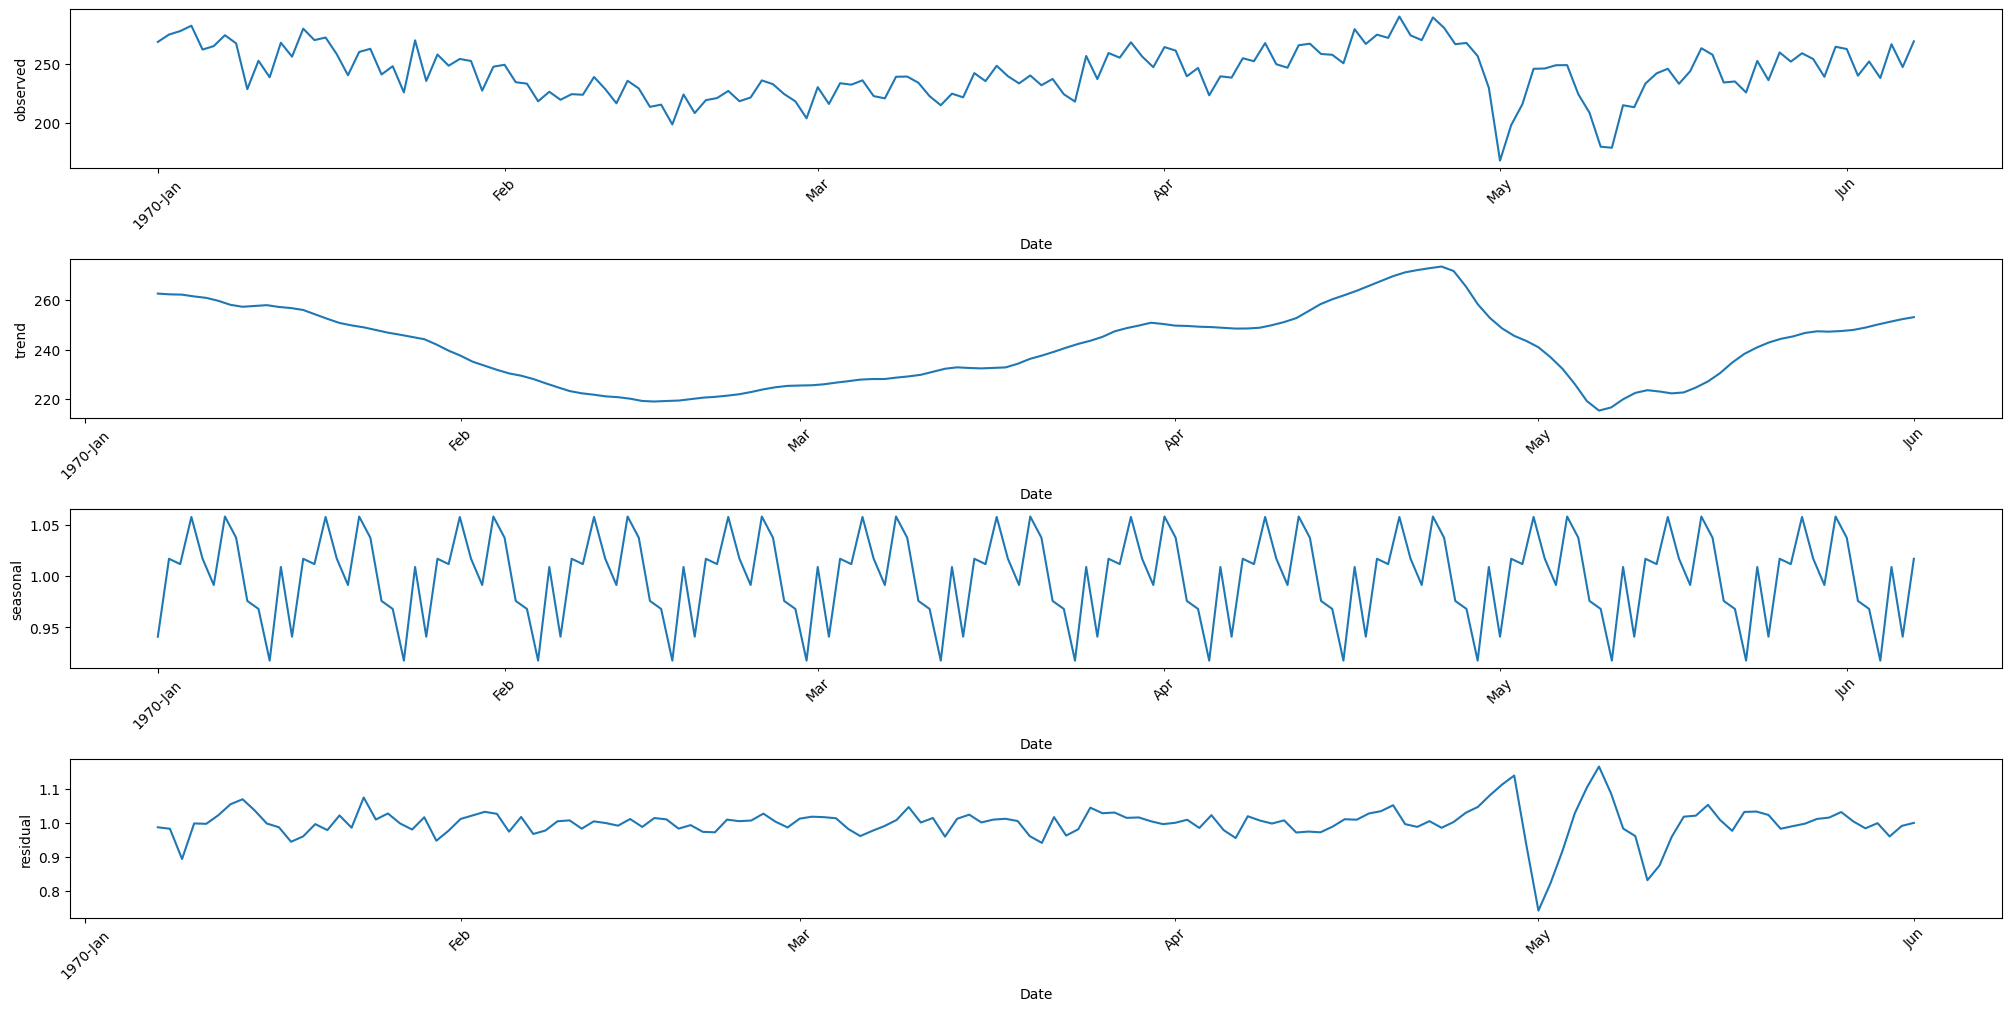

In [43]:
from matplotlib import dates as mdates
years = mdates.YearLocator()    # only print label for the years
months = mdates.MonthLocator()  # mark months as ticks
years_fmt = mdates.DateFormatter('%Y-%b')
fmt = mdates.DateFormatter('%b')

fig, axes = plt.subplots(nrows=4,ncols=1, figsize=(20, 10), constrained_layout=True)
for i, ax in enumerate(axes):
    ax = df_multiplicative.iloc[:,i].plot(ax=ax)
    ax.xaxis.set_major_locator(years)
    ax.xaxis.set_major_formatter(years_fmt)
    ax.xaxis.set_minor_locator(months)
    ax.xaxis.set_minor_formatter(fmt)
    ax.set_ylabel(df_multiplicative.iloc[:,i].name)
    plt.setp(ax.xaxis.get_minorticklabels(), rotation=45)
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)

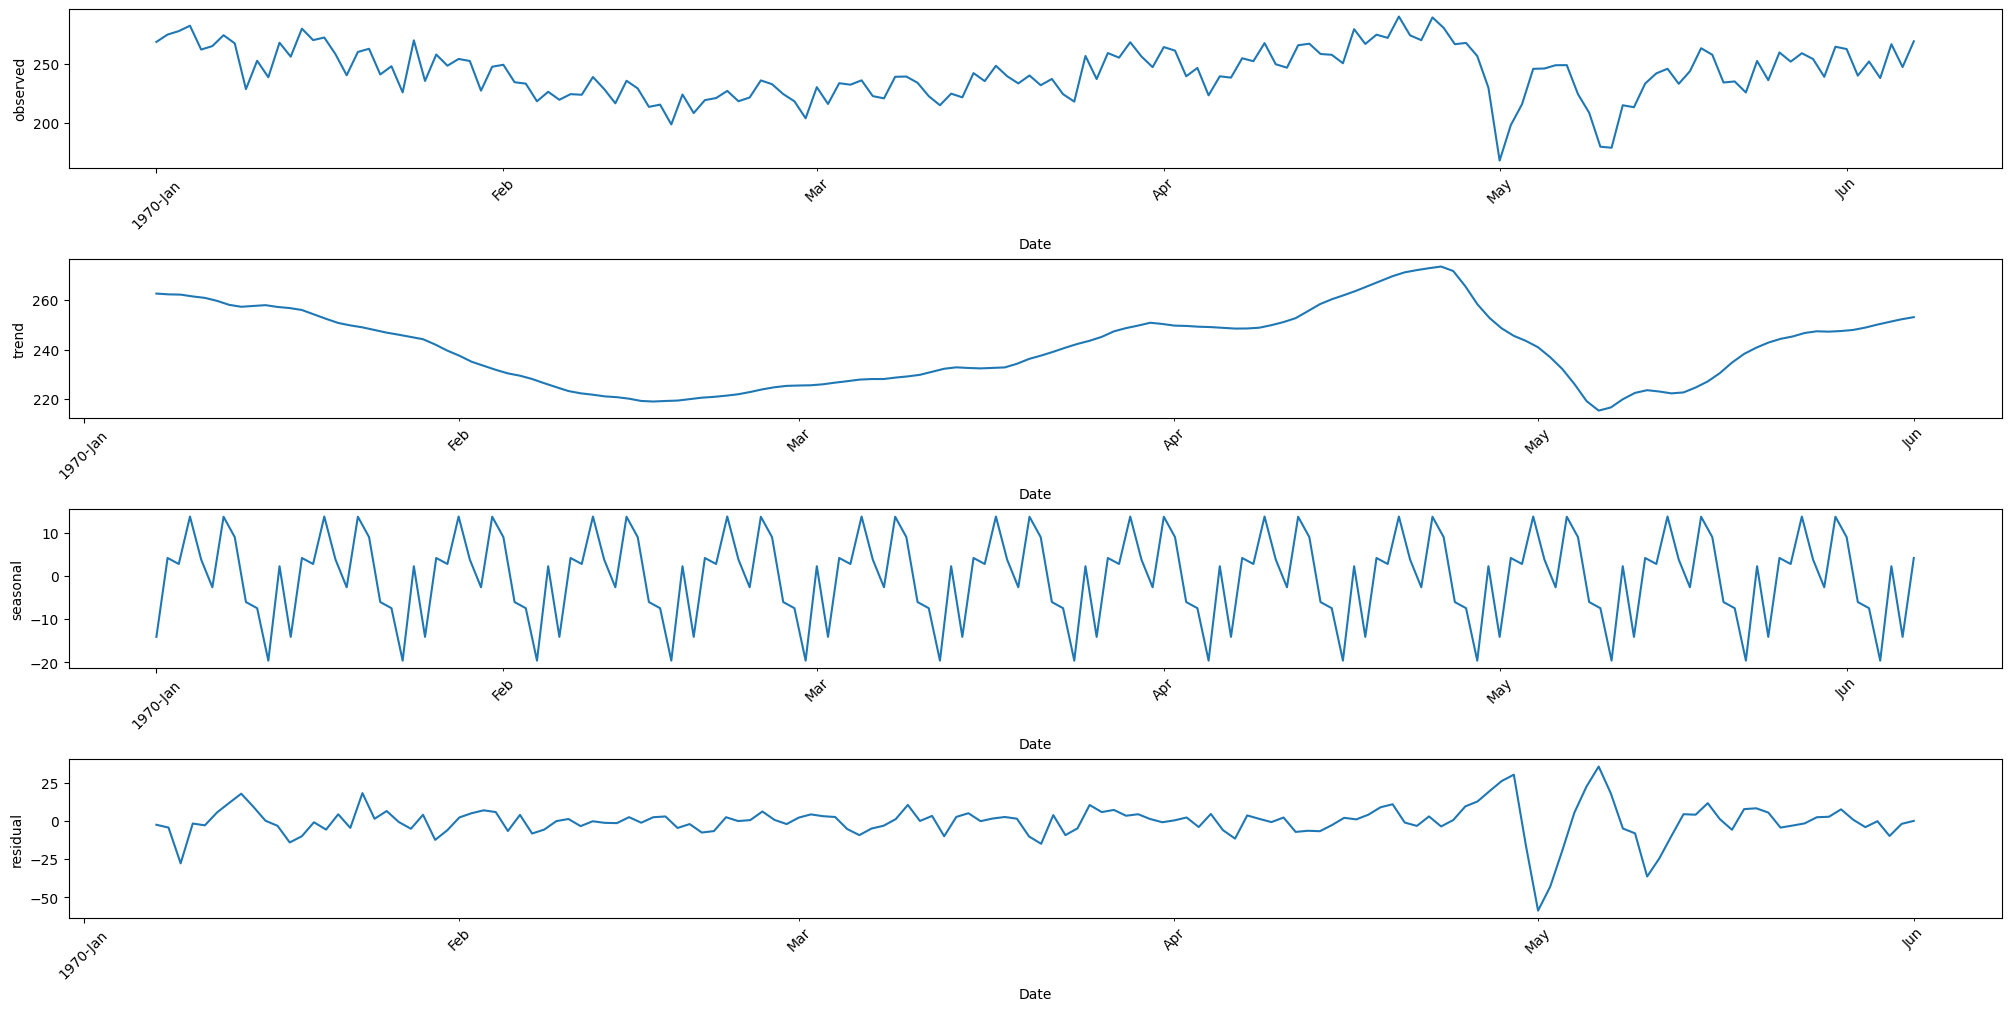

In [46]:
from matplotlib import dates as mdates
years = mdates.YearLocator()    # only print label for the years
months = mdates.MonthLocator()  # mark months as ticks
years_fmt = mdates.DateFormatter('%Y-%b')
fmt = mdates.DateFormatter('%b')

fig, axes = plt.subplots(nrows=4,ncols=1, figsize=(20, 10), constrained_layout=True)
for i, ax in enumerate(axes):
    ax = df_additive.iloc[:,i].plot(ax=ax)
    ax.xaxis.set_major_locator(years)
    ax.xaxis.set_major_formatter(years_fmt)
    ax.xaxis.set_minor_locator(months)
    ax.xaxis.set_minor_formatter(fmt)
    ax.set_ylabel(df_additive.iloc[:,i].name)
    plt.setp(ax.xaxis.get_minorticklabels(), rotation=45)
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)

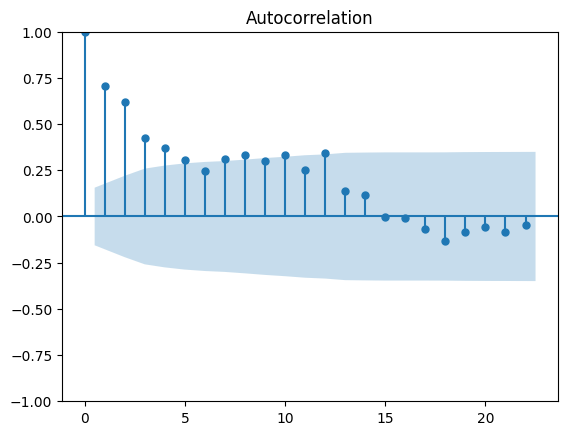

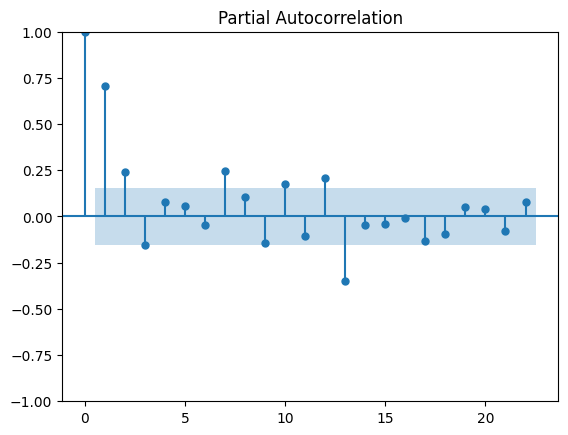

In [60]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

acf_original = plot_acf(df_train)

pacf_original = plot_pacf(df_train)

## ADF test for stationarity

In [48]:
from statsmodels.tsa.stattools import adfuller

adf_test = adfuller(df_train)
print(f'p-value : {adf_test[1]}')

p-value : 0.12551539267057998


In [52]:
adf_test = adfuller(residual.dropna())
print(f'p-value : {adf_test[1]}')

p-value : 2.850722780011215e-18


12

## Transforming data to stationary

In [ ]:
df_train_diff = df_train.diff(12).diff(1).dropna()

print(adfuller(df_train_diff)[1])

df_train_diff.plot(figsize=(12,8))

acf_diff = plot_acf(df_train_diff)

pacf_diff = plot_pacf(df_train_diff)

In [ ]:
acf_diff = plot_acf(df_train_diff)

pacf_diff = plot_pacf(df_train_diff)

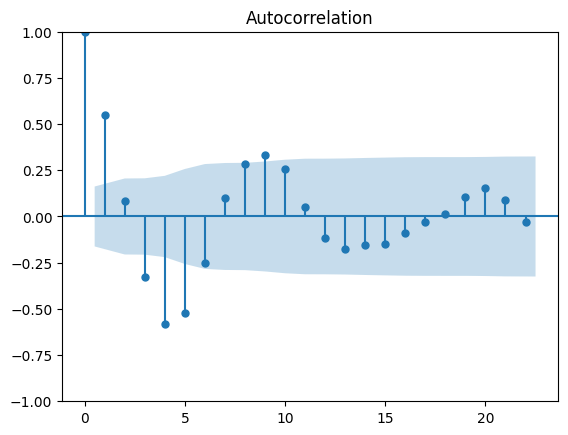

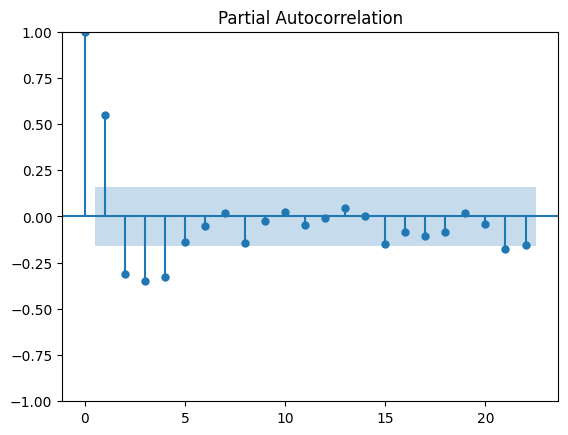

In [62]:
acf_diff = plot_acf(residual.dropna())

pacf_diff = plot_pacf(residual.dropna())

## Fit ARIMA Model

In [57]:
from statsmodels.tsa.arima.model import ARIMA

In [58]:
model = ARIMA(residual, order=(2,1,0))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  resid   No. Observations:                  158
Model:                 ARIMA(2, 1, 0)   Log Likelihood                -553.586
Date:                Thu, 04 Apr 2024   AIC                           1113.171
Time:                        21:16:34   BIC                           1122.340
Sample:                    04-01-2010   HQIC                          1116.895
                         - 05-01-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0196      0.047      0.414      0.679      -0.073       0.112
ar.L2         -0.0617      0.062     -0.993      0.321      -0.184       0.060
sigma2       108.8283      8.213     13.251      0.0

/home/jamie/code/JamieW365/londoncrime/env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/jamie/code/JamieW365/londoncrime/env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/jamie/code/JamieW365/londoncrime/env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


## Check Model Residuals

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
residuals = model_fit.resid[1:]
fig, ax = plt.subplots(1, 2)
residuals.plot(title='Residuals', ax=ax[0])
residuals.plot(title='Density', kind='kde', ax=ax[1])
plt.show()

In [ ]:
acf_resid = plot_acf(residuals)

pacf_resid = plot_pacf(residuals)

## Forecasting with fitted model

In [78]:
df = pd.DataFrame(total_crime_trend)


In [ ]:
forecast_test = model_fit.forecast(len(df_test))

df['forecast'] = [None]*len(df_train) + list(forecast_test)

df.plot()

In [ ]:
forecast_test

## Auto Arima on Residuals

In [66]:
import pmdarima as pm

In [67]:
model = pm.auto_arima(df_train, 
                      m=12,               # frequency of series                      
                      seasonal=True,  # TRUE if seasonal series
                      d=None,             # let model determine 'd'
                      test='adf',         # use adftest to find optimal 'd'
                      start_p=0, start_q=0, # minimum p and q
                      max_p=12, max_q=12, # maximum p and q
                      D=None,             # let model determine 'D'
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=inf, Time=1.29 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=1328.338, Time=0.05 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=1271.177, Time=0.55 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=1289.340, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=1326.338, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=1309.338, Time=0.09 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=1255.514, Time=1.16 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=inf, Time=1.97 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=inf, Time=0.57 sec
 ARIMA(0,1,0)(2,0,0)[12] intercept   : AIC=1254.475, Time=0.31 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=1271.103, Time=0.12 sec
 ARIMA(0,1,0)(2,0,1)[12] intercept   : AIC=inf, Time=1.17 sec
 ARIMA(0,1,1)(2,0,0)[12] intercept   : AIC=1255.485, Time=0.40 sec
 ARIMA(1,1,1)(2,0,0)[12] intercept   : AIC=1257.369, Time=0.47 sec
 ARIMA(0,1,0)(2,0,0)[12]             : 

In [68]:
print(model.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  158
Model:             SARIMAX(0, 1, 0)x(2, 0, 0, 12)   Log Likelihood                -623.238
Date:                            Thu, 04 Apr 2024   AIC                           1252.475
Time:                                    21:24:25   BIC                           1261.644
Sample:                                04-01-2010   HQIC                          1256.199
                                     - 05-01-2023                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12       0.3901      0.051      7.724      0.000       0.291       0.489
ar.S.L24       0.3621      0.065   

In [75]:
model_fit = model.fit()

TypeError: ARIMA.fit() missing 1 required positional argument: 'y'

<Axes: xlabel='Date'>

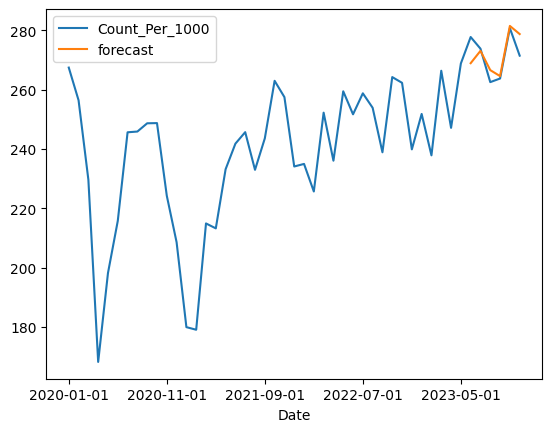

In [86]:
forecast_test = model_fit.predict(n_periods=len(df_test))

df['forecast'] = [None]*len(df_train) + list(forecast_test)

df['2020-01-01':].plot()